In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime

#dados chile
chile_uci =  pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto9/HospitalizadosUCIEtario_T.csv')
chile_mort = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto10/FallecidosEtario_T.csv')

#dados brasil
cols_old = ['DT_ENTUTI','NU_IDADE_N','UTI','CLASSI_FIN','EVOLUCAO','DT_EVOLUCA','DT_SAIDUTI']
brazil_data = pd.read_csv('INFLUD.csv', delimiter=';', usecols = cols_old)

In [140]:
## MANIPULATING BRAZIL DATA ##

#renomear colunas
cols_new = {'NU_IDADE_N':'idade','UTI':'uti','DT_ENTUTI':'data_uti','CLASSI_FIN':'teste_covid', 'EVOLUCAO':'obito','DT_EVOLUCA':'data_obito','DT_SAIDUTI':'saida_uti'}
brazil_data = brazil_data.rename(columns=cols_new)
#formatar colunas para data
brazil_data['data_obito'] = pd.to_datetime(brazil_data['data_obito'], format='%d/%m/%Y')
brazil_data['data_uti'] = pd.to_datetime(brazil_data['data_uti'], format='%d/%m/%Y', errors='coerce')
brazil_data['saida_uti'] = pd.to_datetime(brazil_data['saida_uti'], format='%d/%m/%Y', errors='coerce')

## Dataframes de Mortalidade ##

#selecionar apenas casos de óbito por covid
brazil_mort = brazil_data[(brazil_data['obito'] == 2) & (brazil_data['teste_covid'] == 5)]
#dropar colunas não usadas
brazil_mort = brazil_mort.drop(columns = ['uti','teste_covid','data_uti','obito','data_uti','saida_uti'])
#reagrupar dataframe em semanas e obter a mediana de idade dos mortos a cada semana
brazil_mort_date = brazil_mort.set_index('data_obito').resample('W').median().sort_values(by=['data_obito'])
#dataframes que contam números de mortos por idade no total a cada mes como propoção do total de mortos
#janeiro
brazil_mort_count_jan = brazil_mort[brazil_mort['data_obito'].dt.month == 1]
brazil_mort_count_jan = brazil_mort_count_jan.groupby('idade', as_index = False).count()
brazil_mort_count_jan = brazil_mort_count_jan.rename(columns={'data_obito':'numero_mortos'})
brazil_mort_count_jan['proporcao'] = brazil_mort_count_jan['numero_mortos']/brazil_mort_count_jan['numero_mortos'].sum()
#fevereiro
brazil_mort_count_feb = brazil_mort[brazil_mort['data_obito'].dt.month == 2]
brazil_mort_count_feb = brazil_mort_count_feb.groupby('idade', as_index = False).count()
brazil_mort_count_feb = brazil_mort_count_feb.rename(columns={'data_obito':'numero_mortos'})
brazil_mort_count_feb['proporcao'] = brazil_mort_count_feb['numero_mortos']/brazil_mort_count_feb['numero_mortos'].sum()
#março
brazil_mort_count_mar = brazil_mort[brazil_mort['data_obito'].dt.month == 3]
brazil_mort_count_mar = brazil_mort_count_mar.groupby('idade', as_index = False).count()
brazil_mort_count_mar = brazil_mort_count_mar.rename(columns={'data_obito':'numero_mortos'})
brazil_mort_count_mar['proporcao'] = brazil_mort_count_mar['numero_mortos']/brazil_mort_count_mar['numero_mortos'].sum()

#dataframe separando em grupos de idade
bins = pd.IntervalIndex.from_tuples([(0,9),(10,19),(20,29),(30,39),(40,49),(50,59),(60,69),(70,79),(80,120)])
brazil_mort_age_group = brazil_mort.groupby(pd.cut(brazil_mort['idade'], bins)).count()

## Dataframes de Internação em UTI ##

#selecionar apenas casos de covid internados em UTI
brazil_uci = brazil_data[(brazil_data['uti'] == 1) & (brazil_data['teste_covid'] == 5) & (brazil_data['obito'] != 2) & (brazil_data['obito'] != 3)]
#dropar colunas não usadas
brazil_uci = brazil_uci.drop(columns = ['uti','teste_covid','obito','data_obito'])
#dropar dado outlier idade -77
brazil_uci.drop(index=brazil_uci[brazil_uci['idade'] == -77].index, inplace=True)
#criar colunas com dias internados - se saida_uti = NaT então dias internados = hoje - entrada
today = pd.to_datetime('21/03/2021', format='%d/%m/%Y')

brazil_uci['dias_internados'] = brazil_uci['saida_uti'] - brazil_uci['data_uti']
brazil_uci['dias_internados'] = np.where(pd.isna(brazil_uci['saida_uti']), today - brazil_uci['data_uti'], brazil_uci['dias_internados'])
brazil_uci = brazil_uci.dropna().sort_values(by='data_uti')
brazil_uci['dias_internados'] = brazil_uci['dias_internados'].dt.days

#média de dias internados por semana
brazil_uci_dias = brazil_uci.drop(columns = ['saida_uti','idade'])
brazil_uci_dias = brazil_uci_dias.set_index('data_uti').resample('W').mean().sort_values(by='data_uti')
daterange = pd.date_range('2021-01-03','2021-03-21')
brazil_uci_dias = brazil_uci_dias[brazil_uci_dias.index.isin(daterange)]

#dataframe mediana de dias internado por dia de internação
brazil_uci_count = brazil_uci.groupby(['idade'])['idade'].count()

Text(0.5, 1.0, 'Brasil: Média de dias internados em UTI por dia de internação')

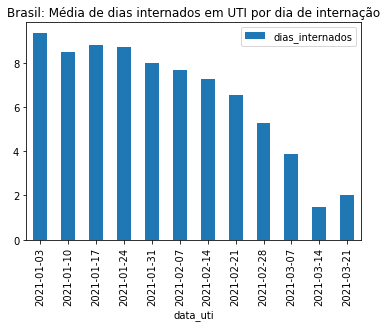

In [181]:
ax1 = brazil_uci_dias.plot(kind='bar')
ax1.set_xticklabels(brazil_uci_dias.index.format())
ax1.set_title("Brasil: Média de dias internados em UTI por dia de internação")

Text(0.5, 1.0, 'Brasil: % de óbitos por idade a cada mês')

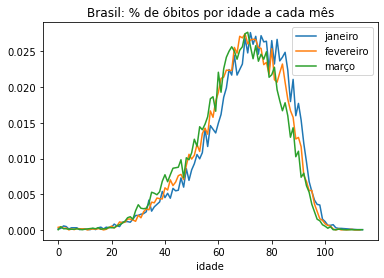

In [178]:
#plotting % deaths per age per month
ax2 = brazil_mort_count_jan.plot(y='proporcao',x='idade')
brazil_mort_count_feb.plot(y='proporcao', x='idade', ax=ax2)
brazil_mort_count_mar.plot(y='proporcao', x='idade', ax=ax2)

ax2.legend(['janeiro','fevereiro','março'])
ax2.set_title('Brasil: % do total de óbitos por idade a cada mês')

Text(0.5, 1.0, 'Brasil: Idade mediana dos falecidos por covid')

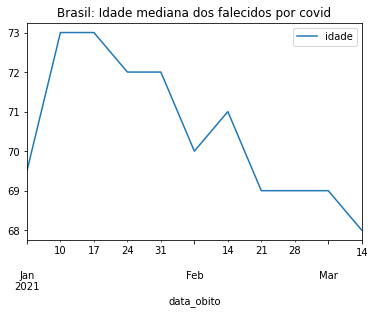

In [179]:
#mediana da idade dos mortos por dia
ax3 = brazil_mort_date.plot()
ax3.set_title("Brasil: Idade mediana dos falecidos por covid")

In [186]:
### MANIPULATING CHILE DATA ###

## Dataframes de Mortalidade ##

#renomear coluna
chile_mort = chile_mort.rename(columns = {'Grupo de edad':'date'})
#formatar data
chile_mort['date'] = pd.to_datetime(chile_mort['date'])
#obter óbitos como % do total do dia
chile_mort.loc[:,"<=39":">=90"] = chile_mort.loc[:,"<=39":">=90"].div(chile_mort.loc[:,"<=39":">=90"].sum(axis=1), axis=0)

## Dataframes de UTI ##
chile_uci = chile_uci.rename(columns = {'Grupo de edad':'date'})
chile_uci['date'] = pd.to_datetime(chile_uci['date'])
chile_uci.loc[:,"<=39":">=70"] = chile_uci.loc[:,"<=39":">=70"].div(chile_uci.loc[:,"<=39":">=70"].sum(axis=1), axis=0)



Text(2021-01-04 00:00:00, 0.35, 'Vacinação')

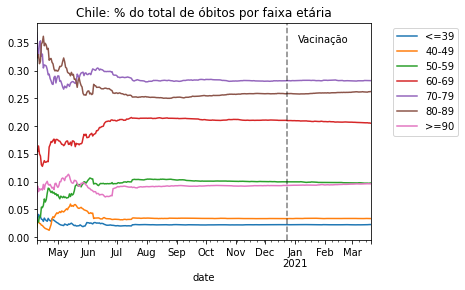

In [194]:
start_vaccination_line = datetime.datetime(2020,12,24)
start_vaccination_text = datetime.datetime(2021,1,4)

ax4 = chile_mort.plot(x='date')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.set_title("Chile: % do total de óbitos por faixa etária")
ax4.axvline(x=start_vaccination_line, linestyle='dashed', alpha=0.5, color='black')
ax4.text(x=start_vaccination_text, y=0.35, s='Vacinação', color='black')

Text(2021-01-04 00:00:00, 0.37, 'Vacinação')

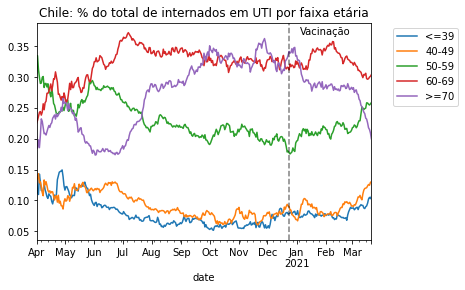

In [198]:
ax5 = chile_uci.plot(x='date')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax5.set_title("Chile: % do total de internados em UTI por faixa etária")
ax5.axvline(x=start_vaccination_line, linestyle='dashed', alpha=0.5, color='black')
ax5.text(x=start_vaccination_text, y=0.37, s='Vacinação', color='black')